In [1]:
import prospect
print(prospect.__version__)

from functions import *

1.4.0


In [2]:
import os
os.environ['SPS_HOME'] = '/home/rita13santos/PhD/fsps'
import fsps

import dynesty
import sedpy
import h5py, astropy
import numpy as np
import astroquery

Importing data

In [3]:
import astropy.io.fits as fits

#import data
file_name="../SN2010ev.fits"
data = fits.open(file_name)
cube = data[1].data   # this is the cube, a (3681 x 341 x 604) matrix with fluxes at different 3681 wavelengths and 308 x 318 spatial pixels ("spaxels")
header = data[1].header # this has information on the data cube
ecube = data[2].data # this is the cube uncertainty (3681 x 341 x 604)
print(np.shape(cube))


print(cube[0])
print(cube[0][200][300])

x_len=len(cube[0][0])
y_len=len(cube[0])

#  -- following is to the get the wavelength array
CRVAL = float(header["CRVAL3"])
NAXIS = int(header["NAXIS3"])
CDELT = float(header["CD3_3"])
CRPIX = float(header["CRPIX3"])
wave = np.array(CRVAL + CDELT * (np.arange(NAXIS) - CRPIX))

(3681, 341, 604)
[[     nan      nan      nan ...      nan      nan      nan]
 [     nan      nan      nan ...      nan      nan      nan]
 [     nan      nan      nan ...      nan      nan      nan]
 ...
 [     nan      nan      nan ... 69.65055      nan      nan]
 [     nan      nan      nan ... 68.30897      nan      nan]
 [     nan      nan      nan ...      nan      nan      nan]]
91.866684


In [10]:
x_center, y_center = int(x_len/2), int(y_len/2)
x_half, y_half = 300, 300

x_min = x_center - x_half
x_max = x_center + x_half
y_min = y_center - y_half
y_max = y_center + y_half


region = cube[:, y_min:y_max, x_min:x_max]
region_err = ecube[:, y_min:y_max, x_min:x_max]

flux = np.nansum(region, axis=(1, 2))/(len(region[0][0])*len(region[0]))
err = np.nansum(region_err, axis=(1, 2))/(len(region[0][0])*len(region[0]))

In [15]:
binned_images = []
binned_err = []

for img in region:
    binned_images.append(binning(img, pix_width=5))
    
for img in region_err:
    binned_err.append(binning(img, pix_width=5))

binned_region = np.array(binned_images)/(len(binned_images[0])*len(binned_images[0][0]))
binned_region_err = np.array(binned_err)/(len(binned_images[0])*len(binned_images[0][0]))

In [16]:
flux = np.nansum(binned_region, axis=(1, 2))
err = np.nansum(binned_region_err, axis=(1, 2))

print(np.shape(flux))

(3681,)


build observation

In [17]:
from sedpy.observate import load_filters
from prospect.utils.obsutils import fix_obs


obs = {
    'wavelength': wave,
    'spectrum': flux,
    'unc': err,
    'redshift': 0.009213,
    'filters': None,
    'phot_mask': None
}

obs['wavelength'] = np.array(obs['wavelength'], dtype=np.float64)
obs['spectrum'] = np.array(obs['spectrum'], dtype=np.float64)

set model

In [18]:
from prospect.models.templates import TemplateLibrary
from prospect.models.sedmodel import SedModel
from prospect.models import priors

model_params = TemplateLibrary['parametric_sfh']

model_params['zred']['init'] = 0.009213
model_params['dust_type']['init'] = 1  # Calzetti # Kriek & Conroy, allows for free R_V



"""model_params['dust_index'] = {
    'name': 'dust_index',
    'N': 1,
    'isfree': True,
    'init': 0.0,  # FSPS default = Calzetti-like
    'prior': priors.TopHat(mini=-1.0, maxi=1.0),  # Typical allowed range
    'units': '',
    'depends_on': None
}"""

for k, p in model_params.items():
    if k in ['mass', 'logzsol', 'dust2', 'dust_index', 'tage']:
        p['isfree'] = True
    elif k in['zred','tau']:
        p['isfree'] = False


model = SedModel(model_params)

print(model_params)

{'zred': {'N': 1, 'isfree': False, 'init': 0.009213, 'units': 'redshift', 'prior': <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=4.0), 'name': 'zred'}, 'mass': {'N': 1, 'isfree': True, 'init': 10000000000.0, 'units': 'Solar masses formed', 'prior': <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0), 'name': 'mass'}, 'logzsol': {'N': 1, 'isfree': True, 'init': -0.5, 'units': '$\\log (Z/Z_\\odot)$', 'prior': <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19), 'name': 'logzsol'}, 'dust2': {'N': 1, 'isfree': True, 'init': 0.6, 'units': 'optical depth at 5500AA', 'prior': <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0), 'name': 'dust2'}, 'sfh': {'N': 1, 'isfree': False, 'init': 4, 'units': 'FSPS index', 'name': 'sfh'}, 'tage': {'N': 1, 'isfree': True, 'init': 1, 'units': 'Gyr', 'prior': <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8), 'name': 'tage'}, 'imf_type': {'N': 1, 'isfree': False, 'init': 2, 'name': 'imf_type'}

In [19]:
print(model)

#mass: Total stellar mass formed (in solar masses)
#logzsol: Logarithmic metallicity
#dust2:  V-band dust attenuation (like A_V)
#tage: Age of the galaxy (time since star formation began)
#tau: Star formation timescale (for parametric SFHs, like τ-model)
#dust_index:Slope of the dust curve (like R_V; only used with dust_type=2)

:::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.009213] 
  sfh: [4] 
  imf_type: [2] 
  dust_type: [1] 
  tau: [1] 


In [20]:
noise_model = (None, None)

In [21]:
from prospect.sources import CSPSpecBasis
sps = CSPSpecBasis(zcontinuous=1)
print(sps.ssp.libraries)

(b'mist', b'miles', b'DL07')


make a prediction

In [22]:
current_parameters = ",".join([f"{p}={v}" for p, v in zip(model.free_params, model.theta)])
print(current_parameters)
spec, phot, mfrac = model.predict(model.theta, obs=obs, sps=sps)

mass=10000000000.0,logzsol=-0.5,dust2=0.6,tage=1.0


fit

In [23]:
from prospect.fitting import lnprobfn, fit_model
fitting_kwargs = dict(nlive_init=400, nested_method="rwalk", nested_target_n_effective=1000, nested_dlogz_init=0.05)
output = fit_model(obs, model, sps, optimize=False, dynesty=True, noise=noise_model, **fitting_kwargs,verbose=True)
result, duration = output["sampling"]

iter: 478 | batch: 0 | nc: 1 | ncall: 3609 | eff(%): 13.245 | logz: -16266.510 +/-    nan | dlogz:  0.000 >  0.050      


done dynesty (initial) in 347.76958894729614s


iter: 1837 | batch: 6 | nc: 1 | ncall: 4993 | eff(%): 28.158 | loglstar:   -inf < -16266.450 < -16266.512 | logz: -16266.506 +/-  0.025 | stop:  1.082    

done dynesty (dynamic) in 10.673799991607666s


In [24]:
from prospect.io import write_results as writer
hfile = "./quickstart_dynesty_mcmc.h5"
writer.write_hdf5(hfile, {}, model, obs,
                 output["sampling"][0], None,
                 sps=sps,
                 tsample=output["sampling"][1],
                 toptimize=0.0)

/home/rita13santos/anaconda3/lib/python3.9/site-packages/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
  warnings.warn("Could not store paramfile text", RuntimeWarning)
/home/rita13santos/anaconda3/lib/python3.9/site-packages/prospect/io/write_results.py:301: RuntimeWarning: Could not JSON serialize model_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),
/home/rita13santos/anaconda3/lib/python3.9/site-packages/prospect/io/write_results.py:49: RuntimeWarning: Could not obtain prospector version info
  warnings.warn("Could not obtain prospector version info", RuntimeWarning)


Appending current time (25Apr24-10.39) to output file in order to guarantee a unique name.
New output filename: ./quickstart_dynesty_mcmc_25Apr24-10.39.h5


plotting

In [25]:
from prospect.io import read_results as reader
hfile = "./quickstart_dynesty_mcmc.h5"
out, out_obs, out_model = reader.results_from(hfile)

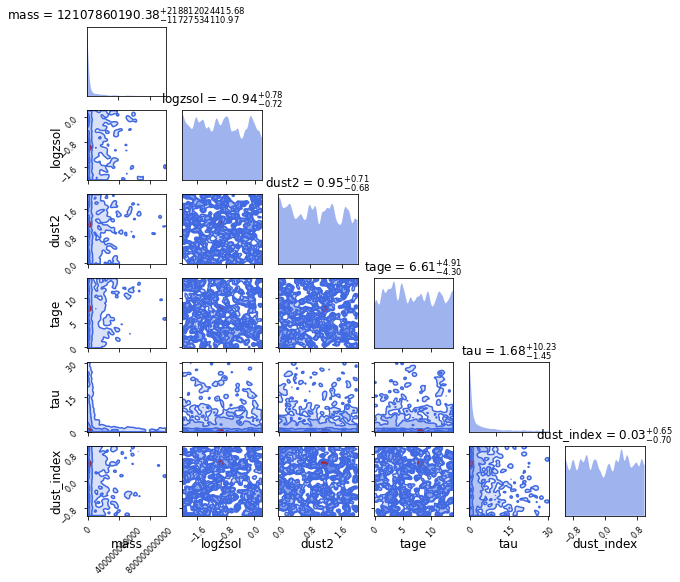

In [26]:
import matplotlib.pyplot as pl
from prospect.plotting import corner
nsamples, ndim = out["chain"].shape
cfig, axes = pl.subplots(ndim, ndim, figsize=(10,9))
axes = corner.allcorner(out["chain"].T, out["theta_labels"], axes, weights=out["weights"], color="royalblue", show_titles=True)

from prospect.plotting.utils import best_sample
pbest = best_sample(out)
corner.scatter(pbest[:, None], axes, color="firebrick", marker="o")